In [0]:
import os
import pickle as pkl
from urllib.request import urlretrieve

import numpy as np
import torch
from torch.utils.data import Dataset

from __future__ import print_function
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import os

import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")
batch_size = 64
log_interval = 100
epochs = 10
root = os.getcwd()
print(f"Current working directory: {root}")

Current working directory: /content


In [0]:
def load_mnist_binarized(root):
    datapath = os.path.join(root, 'bin-mnist')
    if not os.path.exists(datapath):
        os.makedirs(datapath)
    dataset = os.path.join(datapath, "mnist.pkl.gz")

    if not os.path.isfile(dataset):

        datafiles = {
            "train": "http://www.cs.toronto.edu/~larocheh/public/"
                     "datasets/binarized_mnist/binarized_mnist_train.amat",
            "valid": "http://www.cs.toronto.edu/~larocheh/public/datasets/"
                     "binarized_mnist/binarized_mnist_valid.amat",
            "test": "http://www.cs.toronto.edu/~larocheh/public/datasets/"
                    "binarized_mnist/binarized_mnist_test.amat"
        }
        datasplits = {}
        for split in datafiles.keys():
            print("Downloading %s data..." % (split))
            datasplits[split] = np.loadtxt(urlretrieve(datafiles[split])[0])

        pkl.dump([datasplits['train'], datasplits['valid'], datasplits['test']], open(dataset, "wb"))

    x_train, x_valid, x_test = pkl.load(open(dataset, "rb"))
    return x_train, x_valid, x_test


class BinMNIST(Dataset):
    """Binary MNIST dataset"""

    def __init__(self, data, device='cpu', transform=None):
        h, w, c = 28, 28, 1
        self.device = device
        self.data = torch.tensor(data, dtype=torch.float).view(-1, c, h, w)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample.to(self.device)


def get_binmnist_datasets(root, device='cpu'):
    x_train, x_valid, x_test = load_mnist_binarized(root)
    x_train = np.append(x_train, x_valid, axis=0)  # https://github.com/casperkaae/LVAE/blob/master/run_models.py (line 401)
    return BinMNIST(x_train, device=device), BinMNIST(x_test, device=device), BinMNIST(x_test, device=device)

In [0]:
x_train, x_valid, x_test = get_binmnist_datasets(root)

train_loader = torch.utils.data.DataLoader(x_train, batch_size=batch_size, shuffle=True, pin_memory=cuda)
test_loader  = torch.utils.data.DataLoader(x_test, batch_size=batch_size, shuffle=True, pin_memory=cuda)

In [0]:
# parser = argparse.ArgumentParser(description='VAE MNIST Example')
# parser.add_argument('--batch-size', type=int, default=128, metavar='N',
#                     help='input batch size for training (default: 128)')
# parser.add_argument('--epochs', type=int, default=10, metavar='N',
#                     help='number of epochs to train (default: 10)')
# parser.add_argument('--no-cuda', action='store_true', default=False,
#                     help='enables CUDA training')
# parser.add_argument('--seed', type=int, default=1, metavar='S',
#                     help='random seed (default: 1)')
# parser.add_argument('--log-interval', type=int, default=10, metavar='N',
#                     help='how many batches to wait before logging training status')
# args = parser.parse_args()
# args.cuda = not args.no_cuda and torch.cuda.is_available()

# torch.manual_seed(args.seed)


# kwargs = {'num_workers': 1, 'pin_memory': True} if args.cuda else {}

# train_loader = torch.utils.data.DataLoader(
#     datasets.MNIST('../data', train=True, download=True,
#                    transform=transforms.ToTensor()),
#     batch_size=batch_size, shuffle=True)
# test_loader = torch.utils.data.DataLoader(
#     datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
#     batch_size=batch_size, shuffle=True)


class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
train_loss_all = []
test_loss_all = []
kl_loss_train = []
kl_loss_test = []
test_loss_all = []


# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    kl = -0.5 * torch.sum(1 + logvar - mu**2 - torch.exp(logvar), dim=1)

    return BCE + KLD, kl.mean()


def train(epoch):
    model.train()
    train_loss = 0
    batch_idx = 0
    batch_kl = []
    batch_elbo = []

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss, kld = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

        batch_kl.append(kld.item())

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))
            
        batch_idx = batch_idx + 1

    kl_loss_train.append(np.mean(batch_kl))

    train_mean = train_loss / len(train_loader.dataset)
    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_mean))
    train_loss_all.append(train_mean)


def test(epoch):
    show_img = True
    datapath = os.path.join(root, 'results')
    if not os.path.exists(datapath):
        os.makedirs(datapath)
    model.eval()
    test_loss = 0
    batch_kl = []
    
    with torch.no_grad():
        for data in test_loader: 
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            loss, kld = loss_function(recon_batch, data, mu, logvar)
            test_loss += loss.item()

            batch_kl.append(kld.item())

            # if i == 0:
            #     n = min(data.size(0), 8)
            #     comparison = torch.cat([data[:n],
            #                           recon_batch.view(batch_size, 1, 28, 28)[:n]])
            #     save_image(comparison.cpu(),
            #              'results/reconstruction_' + str(epoch) + '.png', nrow=n)
     
            recon_batch = recon_batch.to("cpu")

            if show_img:
                # Show input digits
                f, axarr = plt.subplots(8, 8, figsize=(8, 8))
                for i, ax in enumerate(axarr.flat):
                    ax.imshow(data[i].view(28, 28), cmap="binary_r")
                    ax.axis('off')
                plt.suptitle('Inputs')
                plt.show()

                # Show reconstructions
                f, axarr = plt.subplots(8, 8, figsize=(8, 8))
                for i, ax in enumerate(axarr.flat):
                    ax.imshow(recon_batch[i].view(28, 28), cmap="binary_r")
                    ax.axis('off')
                plt.suptitle('Reconstructions')
                plt.show()

                # Show latent space samples        
                with torch.no_grad():
                    sample = torch.randn(64, 20).to(device)
                    sample = model.decode(sample).cpu()
                    f, axarr = plt.subplots(8, 8, figsize=(8, 8))
                    for i, ax in enumerate(axarr.flat):
                        ax.imshow(sample[i].view(28, 28), cmap="binary_r")
                        ax.axis('off')
                    plt.suptitle('Latent space')
                    plt.show()
                show_img = False

    kl_loss_test.append(np.mean(batch_kl))

    test_mean = test_loss / len(test_loader.dataset)
    test_loss_all.append(test_mean)
    print('====> Test set loss: {:.4f}'.format(test_mean))

In [0]:
def plot_data(epoch_list, train_loss_all, test_loss_all, kl_loss_train, kl_loss_test):
        # Overall loss (ELBO)
        plt.plot(epoch_list, train_loss_all, color="blue")
        plt.plot(epoch_list, test_loss_all, color="green", linestyle="--")
        plt.legend(['Training', 'Testing'])
        plt.xlabel('epochs')
        plt.ylabel('loss')
        plt.show()

        # KL loss
        plt.plot(epoch_list, kl_loss_train, color="blue")
        plt.plot(epoch_list, kl_loss_test, color="green", linestyle="--")
        plt.legend(['Training', 'Testing'])
        plt.xlabel('epochs')
        plt.ylabel('KL loss')
        plt.show()

Train Epoch: 1 [0/60000 (0%)]	Loss: 550.472229
Train Epoch: 1 [6400/60000 (11%)]	Loss: 184.948288
Train Epoch: 1 [12800/60000 (21%)]	Loss: 157.741653
Train Epoch: 1 [19200/60000 (32%)]	Loss: 142.817932
Train Epoch: 1 [25600/60000 (43%)]	Loss: 141.337891
Train Epoch: 1 [32000/60000 (53%)]	Loss: 135.649490
Train Epoch: 1 [38400/60000 (64%)]	Loss: 121.254501
Train Epoch: 1 [44800/60000 (75%)]	Loss: 128.641495
Train Epoch: 1 [51200/60000 (85%)]	Loss: 121.322060
Train Epoch: 1 [57600/60000 (96%)]	Loss: 123.612022
====> Epoch: 1 Average loss: 147.3083


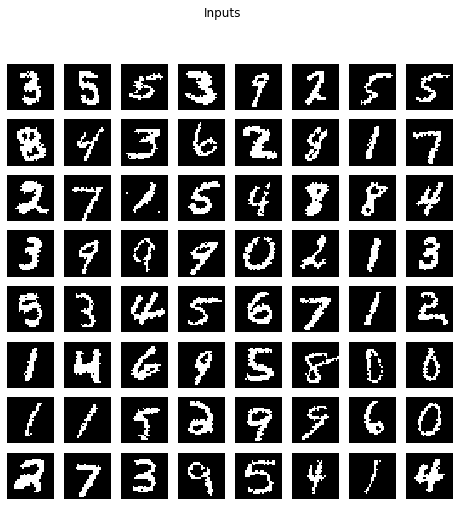

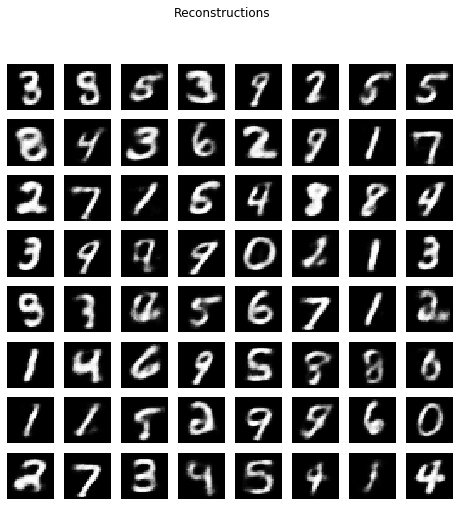

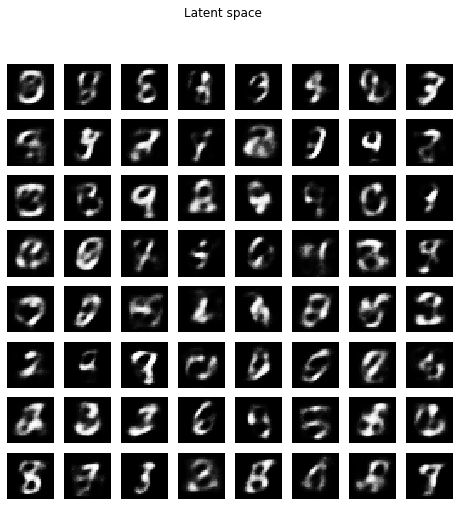

====> Test set loss: 117.1593
Train Epoch: 2 [0/60000 (0%)]	Loss: 118.681908
Train Epoch: 2 [6400/60000 (11%)]	Loss: 126.278442
Train Epoch: 2 [12800/60000 (21%)]	Loss: 114.043945
Train Epoch: 2 [19200/60000 (32%)]	Loss: 117.269539
Train Epoch: 2 [25600/60000 (43%)]	Loss: 113.528778
Train Epoch: 2 [32000/60000 (53%)]	Loss: 112.846962
Train Epoch: 2 [38400/60000 (64%)]	Loss: 117.906158
Train Epoch: 2 [44800/60000 (75%)]	Loss: 112.422165
Train Epoch: 2 [51200/60000 (85%)]	Loss: 112.158516
Train Epoch: 2 [57600/60000 (96%)]	Loss: 113.617188
====> Epoch: 2 Average loss: 113.5420


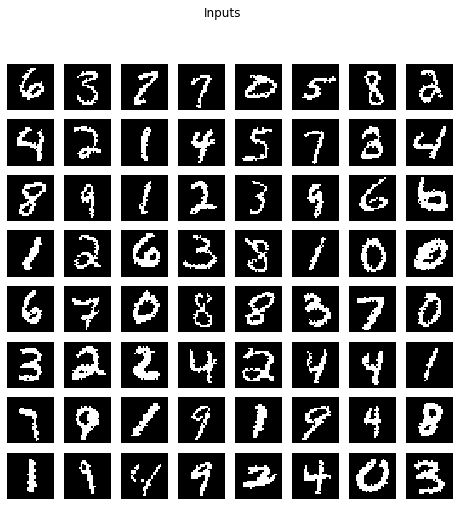

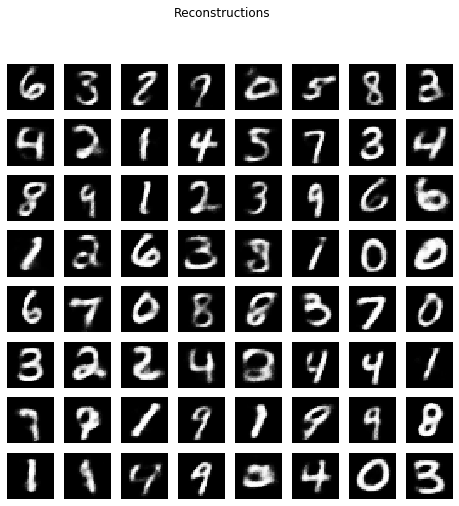

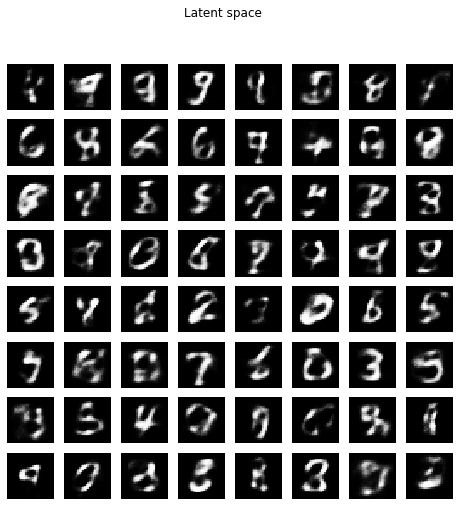

====> Test set loss: 109.6552


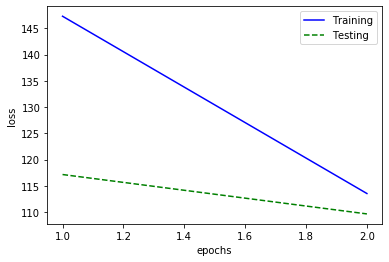

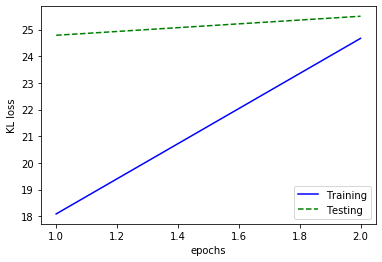

################################################################
Train Epoch: 3 [0/60000 (0%)]	Loss: 109.253403
Train Epoch: 3 [6400/60000 (11%)]	Loss: 109.529312
Train Epoch: 3 [12800/60000 (21%)]	Loss: 110.973701
Train Epoch: 3 [19200/60000 (32%)]	Loss: 106.974167
Train Epoch: 3 [25600/60000 (43%)]	Loss: 101.042664
Train Epoch: 3 [32000/60000 (53%)]	Loss: 105.764313
Train Epoch: 3 [38400/60000 (64%)]	Loss: 110.819443
Train Epoch: 3 [44800/60000 (75%)]	Loss: 115.613373
Train Epoch: 3 [51200/60000 (85%)]	Loss: 110.226883
Train Epoch: 3 [57600/60000 (96%)]	Loss: 106.380539
====> Epoch: 3 Average loss: 108.7622


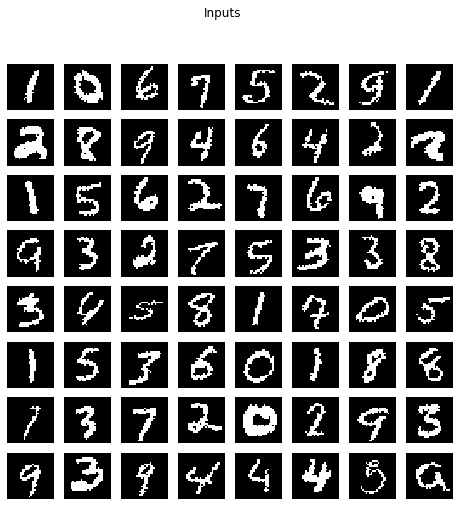

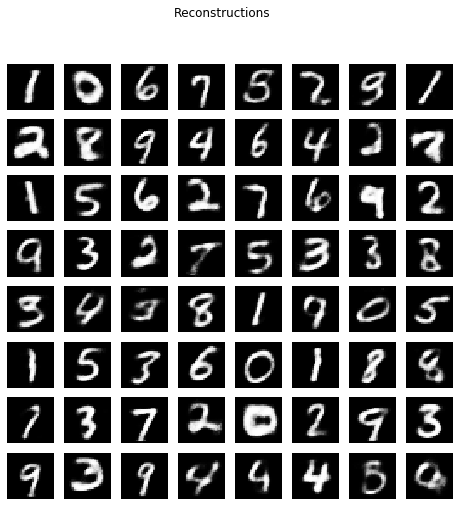

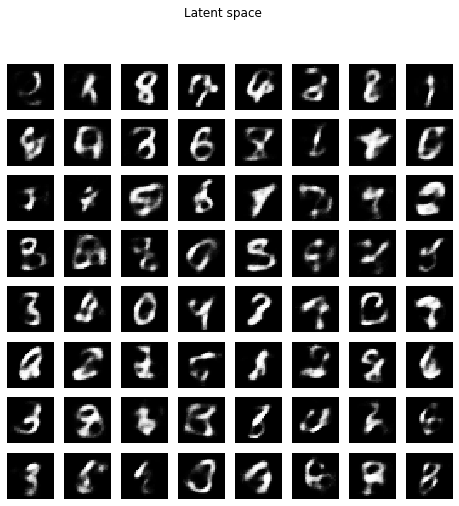

====> Test set loss: 106.6033


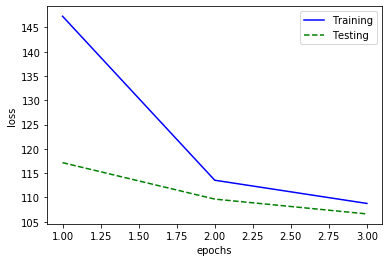

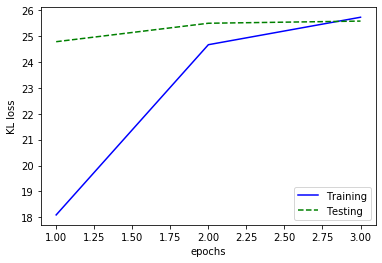

################################################################
Train Epoch: 4 [0/60000 (0%)]	Loss: 102.203796
Train Epoch: 4 [6400/60000 (11%)]	Loss: 99.964661
Train Epoch: 4 [12800/60000 (21%)]	Loss: 104.830399
Train Epoch: 4 [19200/60000 (32%)]	Loss: 107.395676
Train Epoch: 4 [25600/60000 (43%)]	Loss: 107.980911
Train Epoch: 4 [32000/60000 (53%)]	Loss: 110.350136
Train Epoch: 4 [38400/60000 (64%)]	Loss: 105.079971
Train Epoch: 4 [44800/60000 (75%)]	Loss: 105.176437
Train Epoch: 4 [51200/60000 (85%)]	Loss: 106.217125
Train Epoch: 4 [57600/60000 (96%)]	Loss: 108.196457
====> Epoch: 4 Average loss: 106.5382


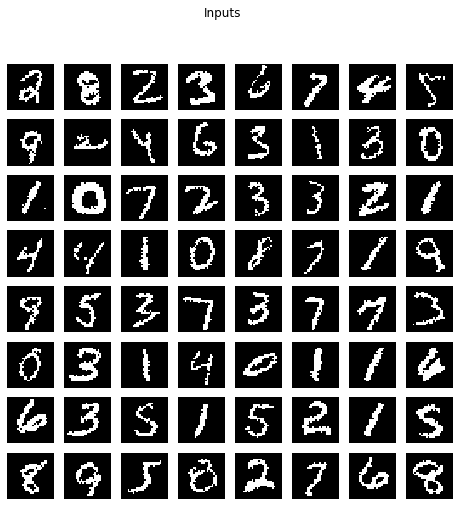

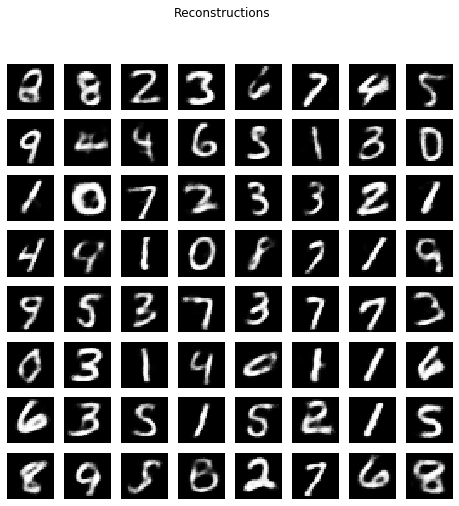

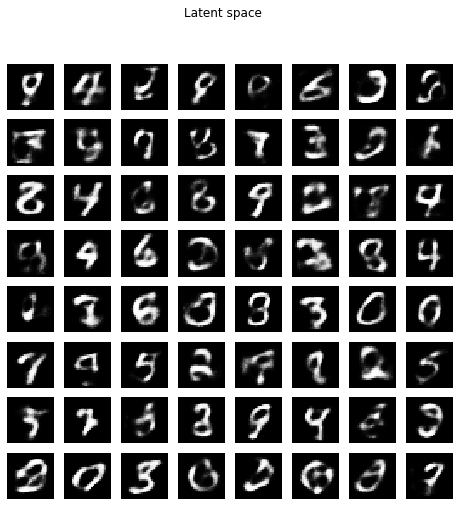

====> Test set loss: 105.1099


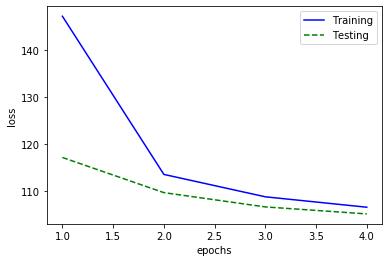

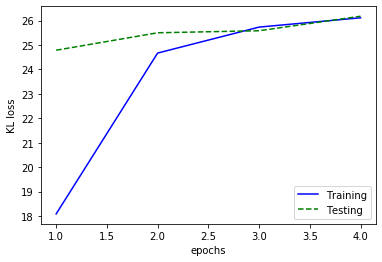

################################################################
Train Epoch: 5 [0/60000 (0%)]	Loss: 100.487457
Train Epoch: 5 [6400/60000 (11%)]	Loss: 104.611824
Train Epoch: 5 [12800/60000 (21%)]	Loss: 102.416183
Train Epoch: 5 [19200/60000 (32%)]	Loss: 98.956451
Train Epoch: 5 [25600/60000 (43%)]	Loss: 106.754944
Train Epoch: 5 [32000/60000 (53%)]	Loss: 102.654358
Train Epoch: 5 [38400/60000 (64%)]	Loss: 104.821350
Train Epoch: 5 [44800/60000 (75%)]	Loss: 105.710419
Train Epoch: 5 [51200/60000 (85%)]	Loss: 101.908318
Train Epoch: 5 [57600/60000 (96%)]	Loss: 113.196815
====> Epoch: 5 Average loss: 105.1713


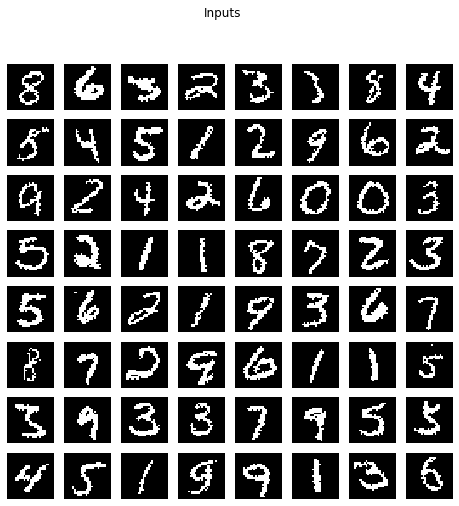

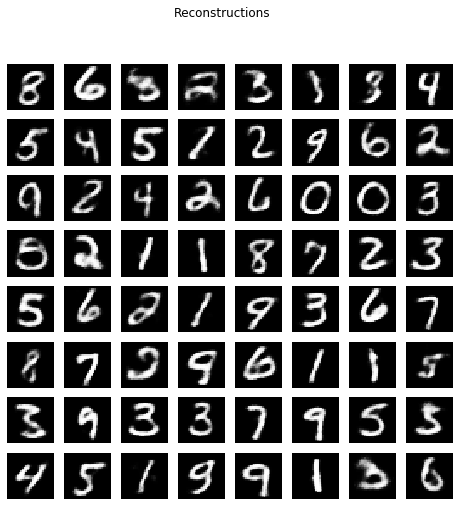

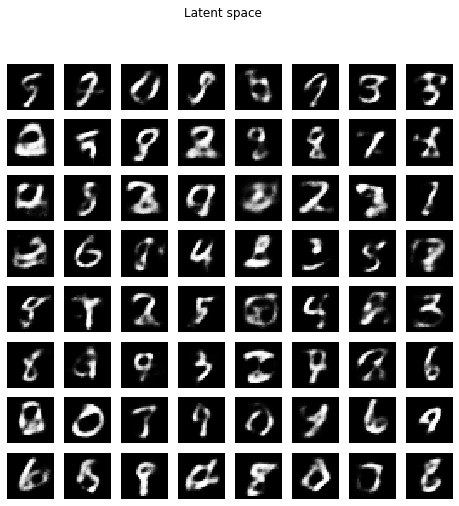

====> Test set loss: 104.3874


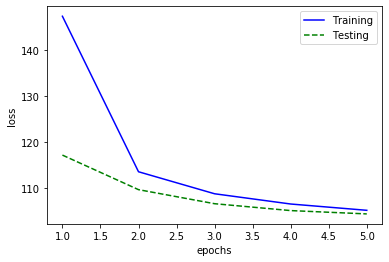

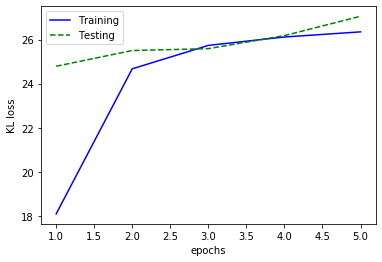

################################################################
Train Epoch: 6 [0/60000 (0%)]	Loss: 107.077835
Train Epoch: 6 [6400/60000 (11%)]	Loss: 104.146172
Train Epoch: 6 [12800/60000 (21%)]	Loss: 106.958893
Train Epoch: 6 [19200/60000 (32%)]	Loss: 100.357330
Train Epoch: 6 [25600/60000 (43%)]	Loss: 102.542450
Train Epoch: 6 [32000/60000 (53%)]	Loss: 105.598671
Train Epoch: 6 [38400/60000 (64%)]	Loss: 102.129486
Train Epoch: 6 [44800/60000 (75%)]	Loss: 107.841812
Train Epoch: 6 [51200/60000 (85%)]	Loss: 103.670624
Train Epoch: 6 [57600/60000 (96%)]	Loss: 101.460106
====> Epoch: 6 Average loss: 104.1971


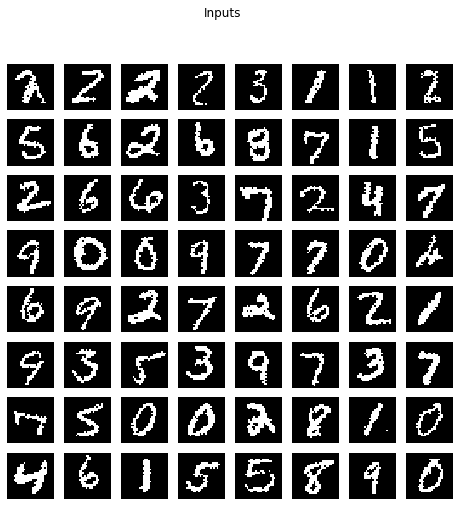

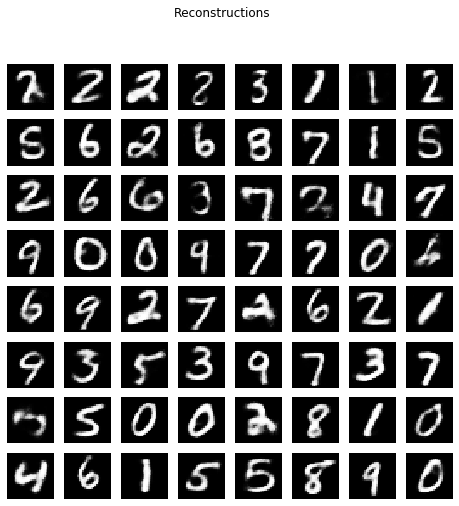

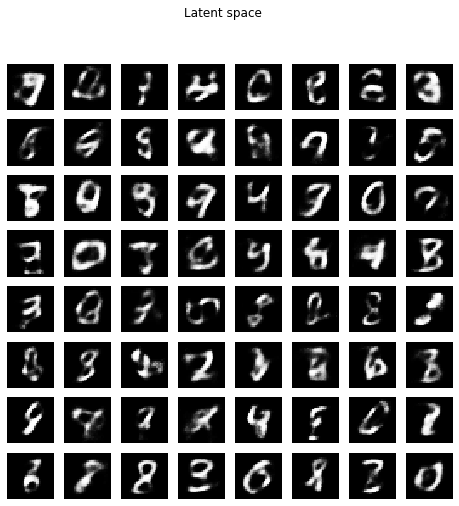

====> Test set loss: 103.6904


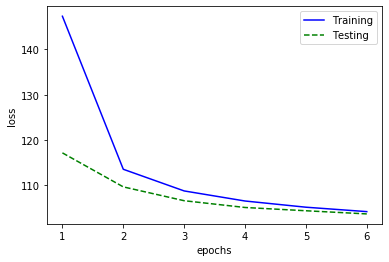

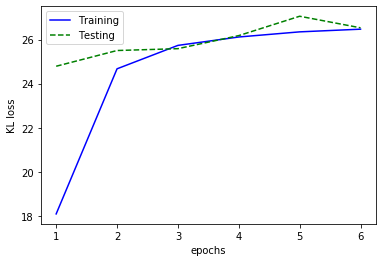

################################################################
Train Epoch: 7 [0/60000 (0%)]	Loss: 103.411011
Train Epoch: 7 [6400/60000 (11%)]	Loss: 99.740753
Train Epoch: 7 [12800/60000 (21%)]	Loss: 98.958038
Train Epoch: 7 [19200/60000 (32%)]	Loss: 107.205521
Train Epoch: 7 [25600/60000 (43%)]	Loss: 108.313698
Train Epoch: 7 [32000/60000 (53%)]	Loss: 105.942764
Train Epoch: 7 [38400/60000 (64%)]	Loss: 103.973152
Train Epoch: 7 [44800/60000 (75%)]	Loss: 100.022957
Train Epoch: 7 [51200/60000 (85%)]	Loss: 106.593384
Train Epoch: 7 [57600/60000 (96%)]	Loss: 103.057144
====> Epoch: 7 Average loss: 103.4944


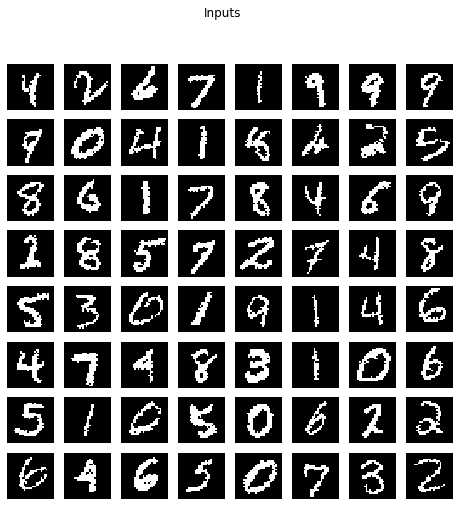

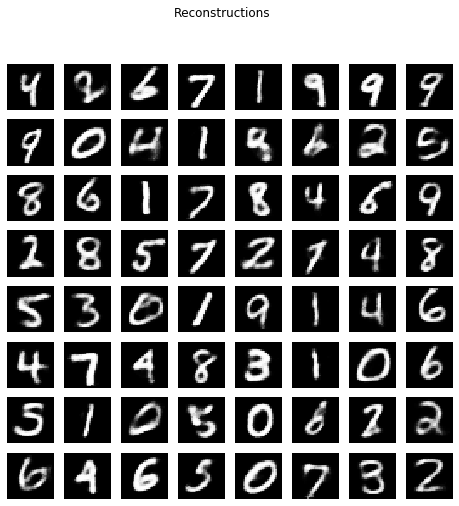

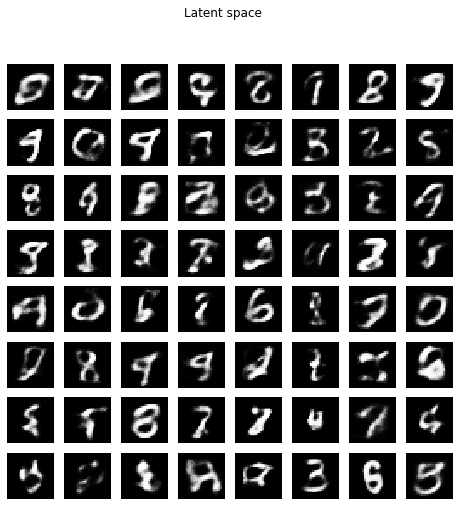

====> Test set loss: 103.3302


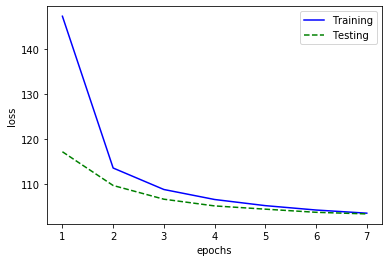

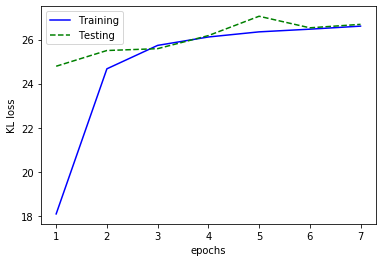

################################################################
Train Epoch: 8 [0/60000 (0%)]	Loss: 95.994835
Train Epoch: 8 [6400/60000 (11%)]	Loss: 105.451439
Train Epoch: 8 [12800/60000 (21%)]	Loss: 106.439178
Train Epoch: 8 [19200/60000 (32%)]	Loss: 103.270561
Train Epoch: 8 [25600/60000 (43%)]	Loss: 108.325073
Train Epoch: 8 [32000/60000 (53%)]	Loss: 99.601837
Train Epoch: 8 [38400/60000 (64%)]	Loss: 99.337265
Train Epoch: 8 [44800/60000 (75%)]	Loss: 106.212799
Train Epoch: 8 [51200/60000 (85%)]	Loss: 100.129639
Train Epoch: 8 [57600/60000 (96%)]	Loss: 96.923599
====> Epoch: 8 Average loss: 102.9597


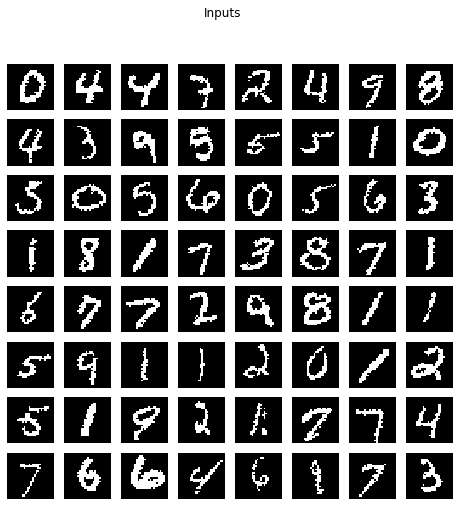

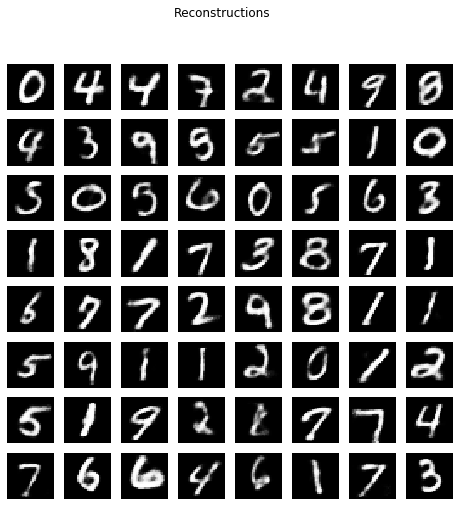

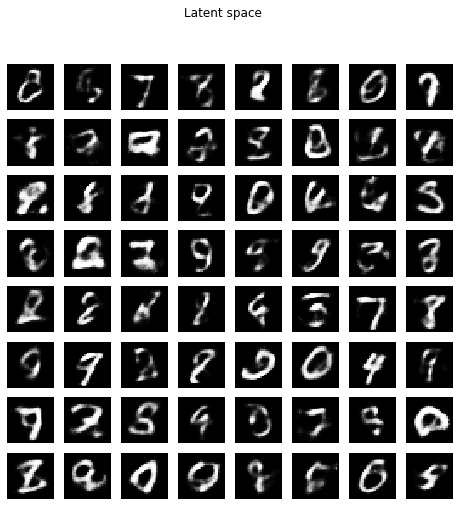

====> Test set loss: 102.9471


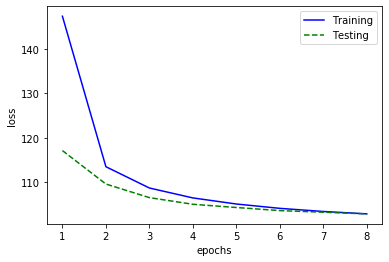

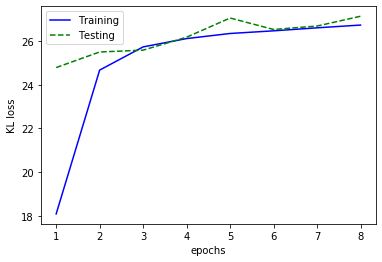

################################################################
Train Epoch: 9 [0/60000 (0%)]	Loss: 103.719376
Train Epoch: 9 [6400/60000 (11%)]	Loss: 99.361710
Train Epoch: 9 [12800/60000 (21%)]	Loss: 97.513451
Train Epoch: 9 [19200/60000 (32%)]	Loss: 105.824219
Train Epoch: 9 [25600/60000 (43%)]	Loss: 98.338341
Train Epoch: 9 [32000/60000 (53%)]	Loss: 102.582031
Train Epoch: 9 [38400/60000 (64%)]	Loss: 100.102119
Train Epoch: 9 [44800/60000 (75%)]	Loss: 99.383698
Train Epoch: 9 [51200/60000 (85%)]	Loss: 102.255463
Train Epoch: 9 [57600/60000 (96%)]	Loss: 102.829727
====> Epoch: 9 Average loss: 102.4576


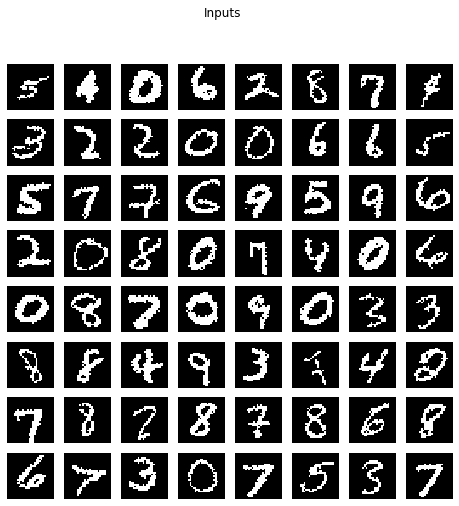

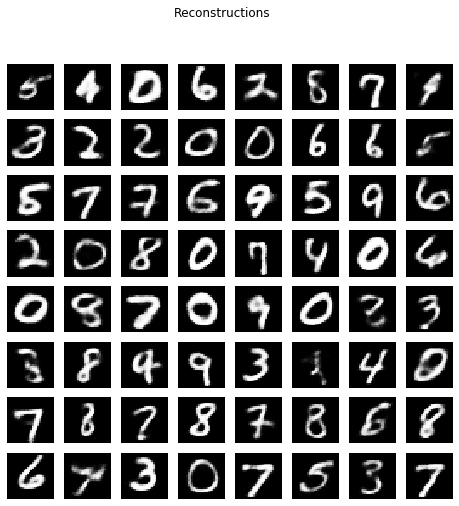

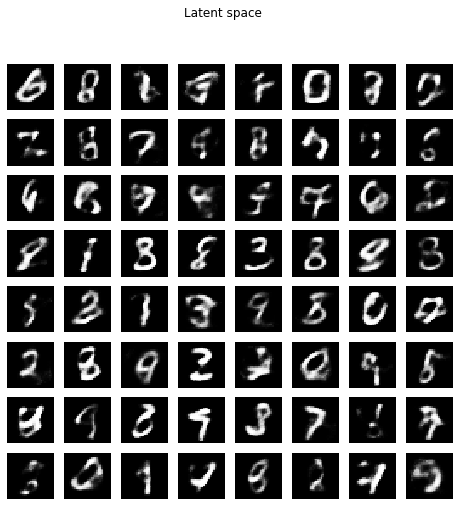

====> Test set loss: 102.4738


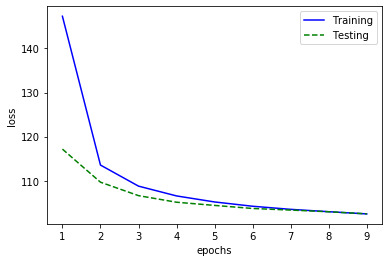

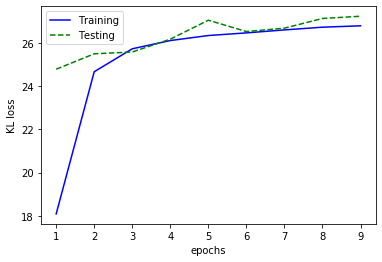

################################################################
Train Epoch: 10 [0/60000 (0%)]	Loss: 100.493683
Train Epoch: 10 [6400/60000 (11%)]	Loss: 105.045708
Train Epoch: 10 [12800/60000 (21%)]	Loss: 104.551224
Train Epoch: 10 [19200/60000 (32%)]	Loss: 101.829048
Train Epoch: 10 [25600/60000 (43%)]	Loss: 101.007324
Train Epoch: 10 [32000/60000 (53%)]	Loss: 96.925491
Train Epoch: 10 [38400/60000 (64%)]	Loss: 101.148575
Train Epoch: 10 [44800/60000 (75%)]	Loss: 97.573196
Train Epoch: 10 [51200/60000 (85%)]	Loss: 98.804138
Train Epoch: 10 [57600/60000 (96%)]	Loss: 110.106964
====> Epoch: 10 Average loss: 102.0901


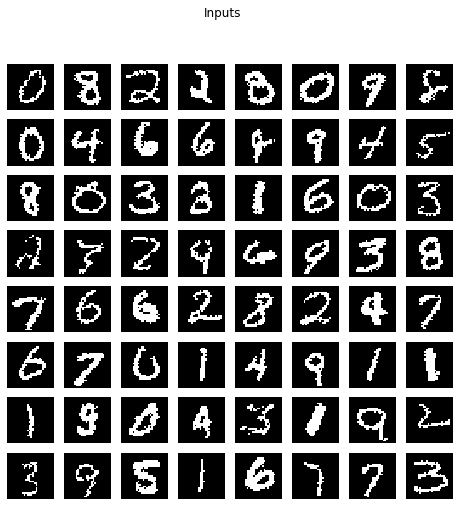

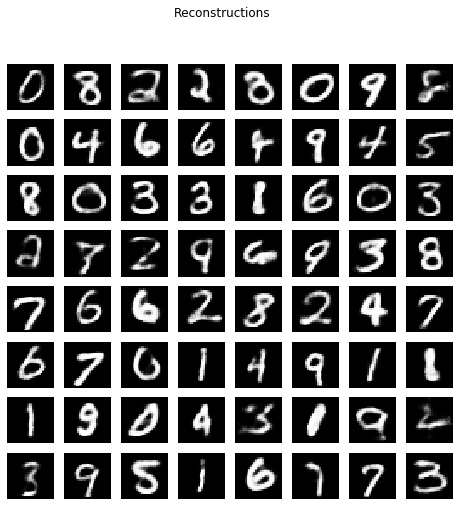

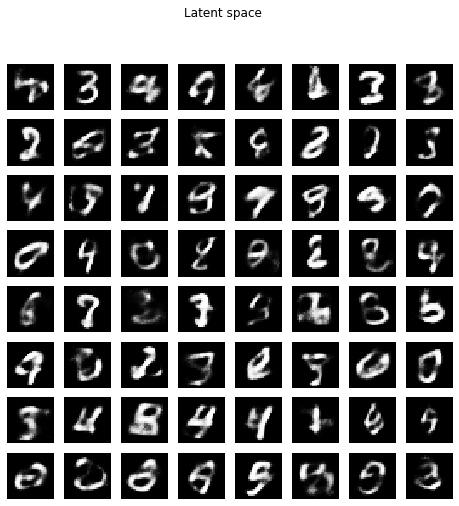

====> Test set loss: 102.4023


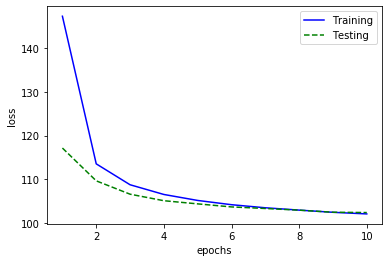

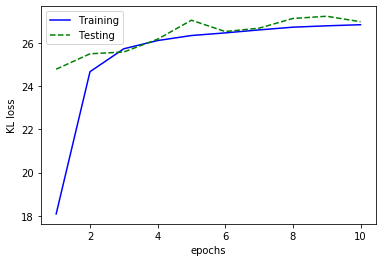

################################################################


In [7]:
if __name__ == "__main__":

    epoch_list = []
    for epoch in range(1, epochs + 1):
        train(epoch)
        test(epoch)
        epoch_list.append(epoch)
        if epoch == 1:
            continue

        plot_data(epoch_list, train_loss_all, test_loss_all, kl_loss_train, kl_loss_test)
        print("################################################################")
            
            # save_image(sample.view(64, 1, 28, 28),
            #            'results/sample_' + str(epoch) + '.png')

        #clear_output(wait=True)
